In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  

In [2]:
# 1. Load dataset
df = pd.read_excel('shipwreckdatabase.xlsx')
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df

,wreck_name,classification,place_of_loss,date_of_loss,description,unnamed:_5,unnamed:_6
0,Actur,Schooner,"Carlingford Bar to Greencastle pier, Carlingfo...",28/12/1894,"Schooner of Dublin, stranded en route to Cunni...",NaN,NaN
1,Anne McLeod,Schooner,"Carlingford, near, Carlingford Lough",22/01/1862,"71-ton, 6-year-old schooner. Captain was Darby...",NaN,NaN
2,Barbara & Jannette,Sloop,"Carlingford Bar, outside, on a rock, Carlingfo...",18/02/1824,"Sloop en route from Irvine to Dundalk, struck ...",NaN,NaN
3,Bee (SS),Iron Steamship,Carlingford Lough entrance/ Helly Hunter Rock,19/10/1888,"88-ton, 18-year-old iron steamship. Owned by ‘...",NaN,NaN
4,Bloom,Schooner,"Carlingford Bar, Carlingford Lough",23/10/1838,"Schooner valued at £600, became a total wreck,...",NaN,NaN
...,...,...,...,...,...,...,...
28229,Sovereign of the Seas,Clipper,Pyramid Shoal.,6 August 1859,A clipper that was wrecked on the Pyramid Shoal.,NaN,NaN
28230,Takao,heavy cruiser,NaN,1946-10-19 00:00:00,A Takao-class heavy cruiser that was surrender...,NaN,NaN
28231,U-181,U-Boat,Port Klang,1946-02-12 00:00:00,A Type IXD2 U-boat that was scuttled near Port...,NaN,NaN
28232,U-859,U-Boat,NaN,1944-09-23 00:00:00,A Type IXD2 U-boat that was sunk by HMSÂ Trenc...,NaN,NaN


In [3]:
 # Ensure description is string
df['description'] = df['description'].astype(str)
print(f"Dataset shape: {df.shape}")
print("Classification labels:", df['classification'].unique())

Dataset shape: (28234, 7)
Classification labels: ['Schooner' 'Sloop' 'Iron Steamship' 'Brig' 'Unknown' 'Lugger' 'Snow'
 'Steamship' 'Smack' 'Yawl' 'Steel Steamship' 'Cutter' 'Ketch'
 'Brigantine' 'Lighter' 'Barque' 'Yacht' 'Ship' 'Fishing boat'
 'Crane Vessel' 'Tender' 'Barquentine' 'Collier' 'Dutch Galliot'
 'Screw Steamer' 'Flat' 'Bark' 'Boat' 'Trader' 'Carvel' 'Lugsail'
 'Galliot' 'Dandy' 'Clinker' 'Iron Paddle Steam Tug' 'Sailing Ship'
 'Merchant Vessel' 'Pleasure Boat' 'Trawler' 'Pilot boat' 'Barge'
 'Admiralty/ Decoy Ship' 'Steam Trawler' 'Submarine' 'Sailing Boat'
 'Paddler Steamer' 'Motor Boat' 'Packet boat' 'Wherry' 'Coaster' 'Clipper'
 'Cruiser' 'Vessel' 'Iron Steam Yacht' 'Smack Yacht' 'Hacker' 'Jigger'
 'Tug' 'Wooden Steam Tug' 'Frigate' 'Hobble' 'Steam Tug' 'Stone hacker'
 'Gabbard' 'West Indiaman' 'Skiff' "Man O' War" 'Anti-submarine Drifter'
 'Light Ship' 'Steam Drifter' 'Fishing drifter' 'Lifeboat'
 'Coast Guard Cruiser' 'Iron steam tug' 'Motor Fishing Vessel'
 'Steam P

In [4]:
# Drop rows with missing descriptions
df.dropna(subset=['description'], inplace=True)

In [5]:
print(df[['wreck_name','classification', 'place_of_loss', 'date_of_loss', 'description']].head())

           wreck_name  classification  \
0               Actur        Schooner   
1         Anne McLeod        Schooner   
2  Barbara & Jannette           Sloop   
3            Bee (SS)  Iron Steamship   
4               Bloom        Schooner   

                                       place_of_loss date_of_loss  \
0  Carlingford Bar to Greencastle pier, Carlingfo...   28/12/1894   
1               Carlingford, near, Carlingford Lough   22/01/1862   
2  Carlingford Bar, outside, on a rock, Carlingfo...   18/02/1824   
3      Carlingford Lough entrance/ Helly Hunter Rock   19/10/1888   
4                 Carlingford Bar, Carlingford Lough   23/10/1838   

                                         description  
0  Schooner of Dublin, stranded en route to Cunni...  
1  71-ton, 6-year-old schooner. Captain was Darby...  
2  Sloop en route from Irvine to Dundalk, struck ...  
3  88-ton, 18-year-old iron steamship. Owned by ‘...  
4  Schooner valued at £600, became a total wreck,...  


In [6]:
# 2. Extract cause from description
def extract_cause(desc):
    desc = desc.lower()
    if 'torpedo' in desc:
        return 'torpedoed'
    elif 'mine' in desc:
        return 'mined'
    elif 'ran aground' in desc or 'rock' in desc:
        return 'ran aground'
    elif 'storm' in desc or 'weather' in desc or 'typhoon' in desc or 'cyclone' in desc:
        return 'bad weather'
    elif 'collision' in desc or 'collided' in desc:
        return 'collision'
    elif 'fire' in desc or 'explosion' in desc or 'burn' in desc:
        return 'fire/explosion'
    elif 'sank' in desc or 'sinking' in desc or 'water leakage' in desc or 'flood' in desc:
        return 'sank'
    elif 'naval battle' in desc or 'air raid' in desc or 'gunfire' in desc:
        return 'naval battle'
    elif 'ice' in desc:
        return 'iceberg wreck'
    elif 'scuttle' in desc:
        return 'scuttle'
    elif 'wreck' in desc:
        return 'wrecked'
    elif 'stranded' in desc or 'abandon' in desc or 'foundered' in desc:
        return 'foundered'
    else:
        return 'unknown reasons'



In [7]:
df['cause'] = df['description'].apply(extract_cause)

In [8]:
print("\nLabel distribution (before cleaning):")
print(df['cause'].value_counts())


Label distribution (before cleaning):
cause
unknown reasons    14520
foundered           5191
wrecked             3104
torpedoed            976
sank                 904
ran aground          837
fire/explosion       626
bad weather          592
collision            548
mined                338
naval battle         303
scuttle              244
iceberg wreck         51
Name: count, dtype: int64


In [9]:
#  Remove unknown causes globally
df = df[df['cause'] != 'unknown reasons'].copy()


In [10]:
print("\nLabel distribution (after removing unknown):")
print(df['cause'].value_counts())



Label distribution (after removing unknown):
cause
foundered         5191
wrecked           3104
torpedoed          976
sank               904
ran aground        837
fire/explosion     626
bad weather        592
collision          548
mined              338
naval battle       303
scuttle            244
iceberg wreck       51
Name: count, dtype: int64


In [11]:
df

,wreck_name,classification,place_of_loss,date_of_loss,description,unnamed:_5,unnamed:_6,cause
0,Actur,Schooner,"Carlingford Bar to Greencastle pier, Carlingfo...",28/12/1894,"Schooner of Dublin, stranded en route to Cunni...",NaN,NaN,foundered
1,Anne McLeod,Schooner,"Carlingford, near, Carlingford Lough",22/01/1862,"71-ton, 6-year-old schooner. Captain was Darby...",NaN,NaN,foundered
2,Barbara & Jannette,Sloop,"Carlingford Bar, outside, on a rock, Carlingfo...",18/02/1824,"Sloop en route from Irvine to Dundalk, struck ...",NaN,NaN,ran aground
3,Bee (SS),Iron Steamship,Carlingford Lough entrance/ Helly Hunter Rock,19/10/1888,"88-ton, 18-year-old iron steamship. Owned by ‘...",NaN,NaN,ran aground
4,Bloom,Schooner,"Carlingford Bar, Carlingford Lough",23/10/1838,"Schooner valued at £600, became a total wreck,...",NaN,NaN,wrecked
...,...,...,...,...,...,...,...,...
28222,USSÂ Grenadier,submarine,"Phuket, Thailand",1943-04-22 00:00:00,"A Tambor-class submarine scuttled off Phuket, ...",NaN,NaN,scuttle
28228,MyÅkÅ,cruiser,Port Klang,1946-06-08 00:00:00,A MyÅkÅ-class cruiser that was scuttled near...,NaN,NaN,scuttle
28229,Sovereign of the Seas,Clipper,Pyramid Shoal.,6 August 1859,A clipper that was wrecked on the Pyramid Shoal.,NaN,NaN,wrecked
28231,U-181,U-Boat,Port Klang,1946-02-12 00:00:00,A Type IXD2 U-boat that was scuttled near Port...,NaN,NaN,scuttle


In [12]:
df=df.drop_duplicates()

In [13]:
df

,wreck_name,classification,place_of_loss,date_of_loss,description,unnamed:_5,unnamed:_6,cause
0,Actur,Schooner,"Carlingford Bar to Greencastle pier, Carlingfo...",28/12/1894,"Schooner of Dublin, stranded en route to Cunni...",NaN,NaN,foundered
1,Anne McLeod,Schooner,"Carlingford, near, Carlingford Lough",22/01/1862,"71-ton, 6-year-old schooner. Captain was Darby...",NaN,NaN,foundered
2,Barbara & Jannette,Sloop,"Carlingford Bar, outside, on a rock, Carlingfo...",18/02/1824,"Sloop en route from Irvine to Dundalk, struck ...",NaN,NaN,ran aground
3,Bee (SS),Iron Steamship,Carlingford Lough entrance/ Helly Hunter Rock,19/10/1888,"88-ton, 18-year-old iron steamship. Owned by ‘...",NaN,NaN,ran aground
4,Bloom,Schooner,"Carlingford Bar, Carlingford Lough",23/10/1838,"Schooner valued at £600, became a total wreck,...",NaN,NaN,wrecked
...,...,...,...,...,...,...,...,...
28222,USSÂ Grenadier,submarine,"Phuket, Thailand",1943-04-22 00:00:00,"A Tambor-class submarine scuttled off Phuket, ...",NaN,NaN,scuttle
28228,MyÅkÅ,cruiser,Port Klang,1946-06-08 00:00:00,A MyÅkÅ-class cruiser that was scuttled near...,NaN,NaN,scuttle
28229,Sovereign of the Seas,Clipper,Pyramid Shoal.,6 August 1859,A clipper that was wrecked on the Pyramid Shoal.,NaN,NaN,wrecked
28231,U-181,U-Boat,Port Klang,1946-02-12 00:00:00,A Type IXD2 U-boat that was scuttled near Port...,NaN,NaN,scuttle


In [14]:
df = df.drop(columns=["unnamed:_5", "unnamed:_6"],axis=1)


In [15]:
df

,wreck_name,classification,place_of_loss,date_of_loss,description,cause
0,Actur,Schooner,"Carlingford Bar to Greencastle pier, Carlingfo...",28/12/1894,"Schooner of Dublin, stranded en route to Cunni...",foundered
1,Anne McLeod,Schooner,"Carlingford, near, Carlingford Lough",22/01/1862,"71-ton, 6-year-old schooner. Captain was Darby...",foundered
2,Barbara & Jannette,Sloop,"Carlingford Bar, outside, on a rock, Carlingfo...",18/02/1824,"Sloop en route from Irvine to Dundalk, struck ...",ran aground
3,Bee (SS),Iron Steamship,Carlingford Lough entrance/ Helly Hunter Rock,19/10/1888,"88-ton, 18-year-old iron steamship. Owned by ‘...",ran aground
4,Bloom,Schooner,"Carlingford Bar, Carlingford Lough",23/10/1838,"Schooner valued at £600, became a total wreck,...",wrecked
...,...,...,...,...,...,...
28222,USSÂ Grenadier,submarine,"Phuket, Thailand",1943-04-22 00:00:00,"A Tambor-class submarine scuttled off Phuket, ...",scuttle
28228,MyÅkÅ,cruiser,Port Klang,1946-06-08 00:00:00,A MyÅkÅ-class cruiser that was scuttled near...,scuttle
28229,Sovereign of the Seas,Clipper,Pyramid Shoal.,6 August 1859,A clipper that was wrecked on the Pyramid Shoal.,wrecked
28231,U-181,U-Boat,Port Klang,1946-02-12 00:00:00,A Type IXD2 U-boat that was scuttled near Port...,scuttle


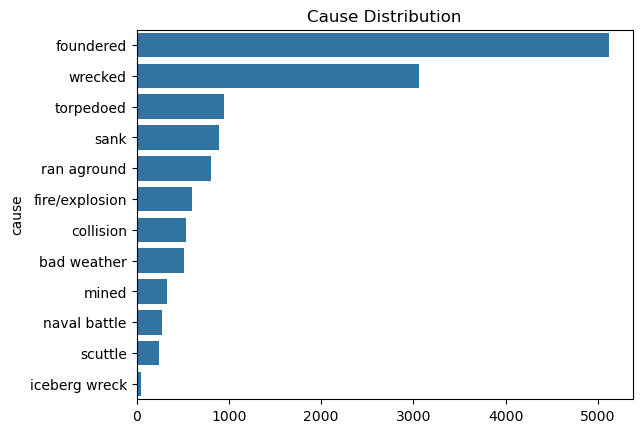

In [16]:
import seaborn as sns
sns.barplot(
    x=df['cause'].value_counts().values,
    y=df['cause'].value_counts().index
)
plt.title("Cause Distribution")
plt.show()


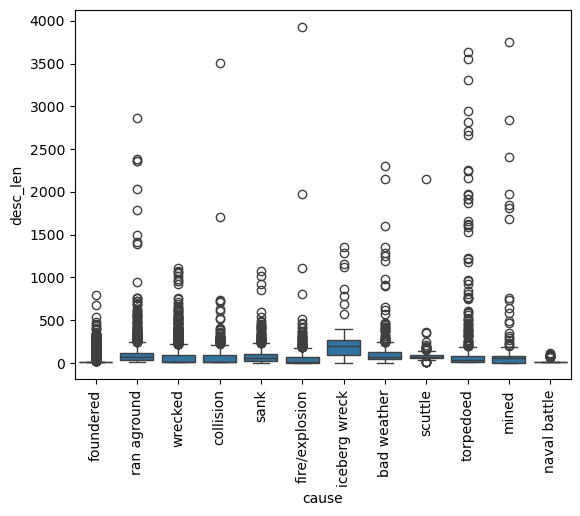

In [17]:
df['desc_len'] = df['description'].str.len()
sns.boxplot(x='cause', y='desc_len', data=df)
plt.xticks(rotation=90)
plt.show()


In [18]:
rare_causes = df['cause'].value_counts()[df['cause'].value_counts() < 100].index
df['cause_clean'] = df['cause'].replace(rare_causes, 'other')


In [19]:
print("\nLabel distribution (after cleaning):")
print(df['cause_clean'].value_counts())



Label distribution (after cleaning):
cause_clean
foundered         5120
wrecked           3063
torpedoed          949
sank               898
ran aground        810
fire/explosion     602
collision          541
bad weather        510
mined              330
naval battle       280
scuttle            243
other               51
Name: count, dtype: int64


C:\Users\PYTHON\AppData\Local\Temp\ipykernel_20168\276304115.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cause_clean', order=df['cause_clean'].value_counts().index, palette='Set2')


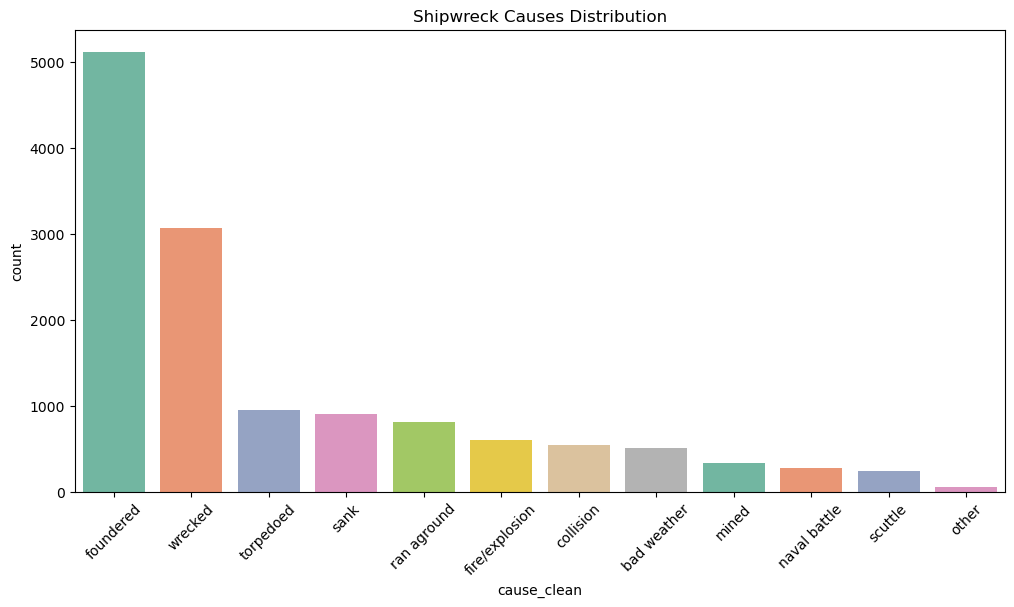

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='cause_clean', order=df['cause_clean'].value_counts().index, palette='Set2')
plt.xticks(rotation=45)
plt.title("Shipwreck Causes Distribution")
plt.show()


In [21]:
#Learning Method
from sklearn.ensemble import RandomForestClassifier
X=df['description']
y=df['cause']

In [22]:
vectorizer= TfidfVectorizer(stop_words='english', max_features=3000)
X_vec = vectorizer.fit_transform(X)

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X_vec,y,test_size=0.2,random_state=42,stratify=y)

In [24]:
model=RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [25]:
y_pred=model.predict(X_test)

In [26]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
                precision    recall  f1-score   support

   bad weather       0.97      0.89      0.93       102
     collision       0.99      0.94      0.96       108
fire/explosion       0.99      0.86      0.92       120
     foundered       0.99      0.99      0.99      1024
 iceberg wreck       0.00      0.00      0.00        10
         mined       0.80      0.71      0.75        66
  naval battle       1.00      1.00      1.00        56
   ran aground       0.97      0.90      0.93       162
          sank       0.91      0.97      0.94       180
       scuttle       0.89      0.98      0.93        49
     torpedoed       0.97      0.99      0.98       190
       wrecked       0.94      1.00      0.97       613

      accuracy                           0.96      2680
     macro avg       0.87      0.85      0.86      2680
  weighted avg       0.96      0.96      0.96      2680



C:\Users\PYTHON\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PYTHON\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PYTHON\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from sklearn.metrics import accuracy_score

In [28]:
print("Accuracy Score:\n")
print(accuracy_score(y_test,y_pred))

Accuracy Score:

0.9634328358208956


In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
model=DecisionTreeClassifier()

In [31]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
y_pred=model.predict(X_test)

In [33]:
print("Classification Report :\n")
print(classification_report(y_test,y_pred))

Classification Report :

                precision    recall  f1-score   support

   bad weather       0.92      0.92      0.92       102
     collision       0.99      0.98      0.99       108
fire/explosion       0.95      0.87      0.90       120
     foundered       0.99      1.00      0.99      1024
 iceberg wreck       0.17      0.10      0.12        10
         mined       0.73      0.73      0.73        66
  naval battle       0.95      0.98      0.96        56
   ran aground       0.94      0.91      0.93       162
          sank       0.92      0.95      0.93       180
       scuttle       0.92      0.92      0.92        49
     torpedoed       0.99      0.99      0.99       190
       wrecked       0.98      0.98      0.98       613

      accuracy                           0.96      2680
     macro avg       0.87      0.86      0.86      2680
  weighted avg       0.96      0.96      0.96      2680



In [34]:
print("Accuracy Score:\n")
print(accuracy_score(y_test,y_pred))

Accuracy Score:

0.9645522388059702


In [35]:
lr=LogisticRegression(max_iter=1000)

In [36]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [37]:
y_pred=model.predict(X_test)

In [38]:
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

Classification Report: 

                precision    recall  f1-score   support

   bad weather       0.92      0.92      0.92       102
     collision       0.99      0.98      0.99       108
fire/explosion       0.95      0.87      0.90       120
     foundered       0.99      1.00      0.99      1024
 iceberg wreck       0.17      0.10      0.12        10
         mined       0.73      0.73      0.73        66
  naval battle       0.95      0.98      0.96        56
   ran aground       0.94      0.91      0.93       162
          sank       0.92      0.95      0.93       180
       scuttle       0.92      0.92      0.92        49
     torpedoed       0.99      0.99      0.99       190
       wrecked       0.98      0.98      0.98       613

      accuracy                           0.96      2680
     macro avg       0.87      0.86      0.86      2680
  weighted avg       0.96      0.96      0.96      2680



In [39]:
print("Accuracy Score\n")
print(accuracy_score(y_test,y_pred))

Accuracy Score

0.9645522388059702


In [40]:
model=SVC(kernel='linear')
model.fit(X_train,y_train)

SVC(kernel='linear')

In [41]:
y_pred=model.predict(X_test)

In [42]:
print("Classification Report:\n")
print(classification_report(y_test,y_pred))

Classification Report:

                precision    recall  f1-score   support

   bad weather       0.98      0.92      0.95       102
     collision       0.99      0.94      0.97       108
fire/explosion       0.97      0.87      0.92       120
     foundered       0.99      1.00      0.99      1024
 iceberg wreck       0.00      0.00      0.00        10
         mined       0.70      0.68      0.69        66
  naval battle       1.00      0.98      0.99        56
   ran aground       0.97      0.92      0.94       162
          sank       0.92      0.97      0.95       180
       scuttle       0.87      0.96      0.91        49
     torpedoed       1.00      0.98      0.99       190
       wrecked       0.95      1.00      0.97       613

      accuracy                           0.97      2680
     macro avg       0.86      0.85      0.86      2680
  weighted avg       0.96      0.97      0.96      2680



In [43]:
print("Accuracy Score: \n")
print(accuracy_score(y_test,y_pred))

Accuracy Score: 

0.9656716417910448


In [44]:
print("Classification Report:\n")
print(classification_report(y_test,y_pred))

Classification Report:

                precision    recall  f1-score   support

   bad weather       0.98      0.92      0.95       102
     collision       0.99      0.94      0.97       108
fire/explosion       0.97      0.87      0.92       120
     foundered       0.99      1.00      0.99      1024
 iceberg wreck       0.00      0.00      0.00        10
         mined       0.70      0.68      0.69        66
  naval battle       1.00      0.98      0.99        56
   ran aground       0.97      0.92      0.94       162
          sank       0.92      0.97      0.95       180
       scuttle       0.87      0.96      0.91        49
     torpedoed       1.00      0.98      0.99       190
       wrecked       0.95      1.00      0.97       613

      accuracy                           0.97      2680
     macro avg       0.86      0.85      0.86      2680
  weighted avg       0.96      0.97      0.96      2680



In [45]:
feature_names = vectorizer.get_feature_names_out()
print("Number of features:", len(feature_names))
print("First 20 features:", feature_names[:20])


Number of features: 3000
First 20 features: ['000' '006' '007400111' '00am' '10' '100' '1000' '100m' '102' '103' '104'
 '105' '106' '107' '107m' '109' '10ft' '10m' '11' '110']


In [46]:
classes_model = lr.classes_  # classes actually used in the trained model
coefficients = lr.coef_
top_n = 5

for i, class_label in enumerate(classes_model):
    coef = coefficients[i]
    top_idx = np.argsort(coef)[-top_n:]  # top N features
    top_features = [feature_names[j] for j in top_idx]
    top_values = coef[top_idx]
    
    print(f"\nTop {top_n} keywords for class '{class_label}':")
    for word, value in zip(top_features[::-1], top_values[::-1]):  # descending
        print(f"{word} ({value:.3f})")



Top 5 keywords for class 'bad weather':
storm (12.103)
weather (5.767)
cyclone (3.352)
typhoon (2.852)
violent (1.640)

Top 5 keywords for class 'collision':
collided (9.694)
collision (8.353)
sank (1.847)
fishing (1.509)
ss (1.472)

Top 5 keywords for class 'fire/explosion':
caught (7.089)
burned (5.651)
burnt (5.150)
explosion (4.551)
gunfire (3.562)

Top 5 keywords for class 'foundered':
stranded (8.593)
foundered (8.226)
abandoned (5.317)
en (1.860)
route (1.828)

Top 5 keywords for class 'iceberg wreck':
ice (2.739)
rice (2.245)
iceberg (1.162)
ashore (1.122)
service (1.083)

Top 5 keywords for class 'mined':
minesweeper (4.511)
struck (4.137)
sunk (2.974)
minelaying (2.108)
hit (2.033)

Top 5 keywords for class 'naval battle':
air (4.773)
raid (4.744)
naval (4.698)
battle (4.491)
guadalcanal (1.537)

Top 5 keywords for class 'ran aground':
rocks (8.640)
aground (7.775)
ran (7.429)
rock (5.970)
rocket (1.720)

Top 5 keywords for class 'sank':
sank (12.360)
sinking (3.845)
leakage

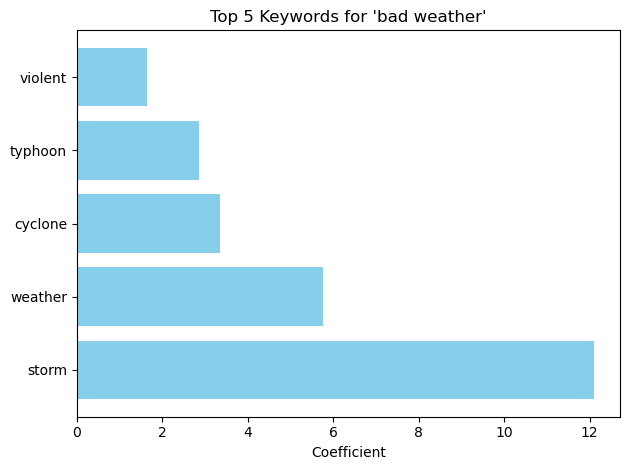

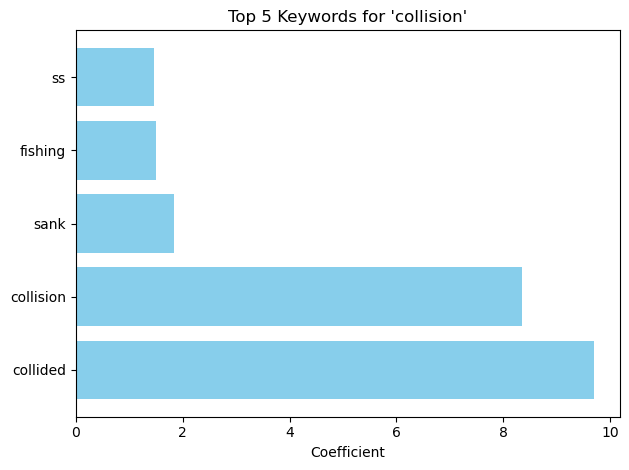

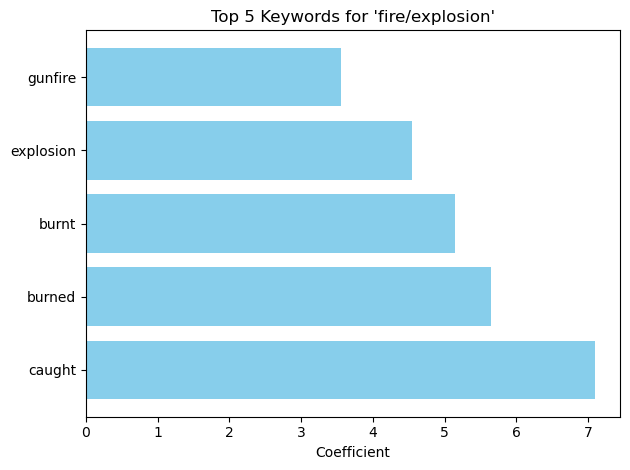

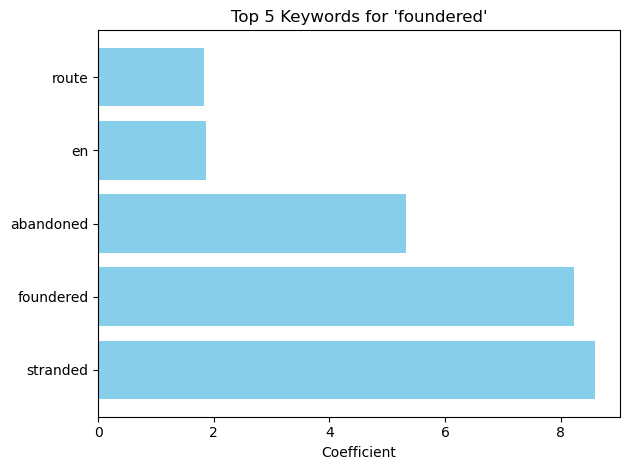

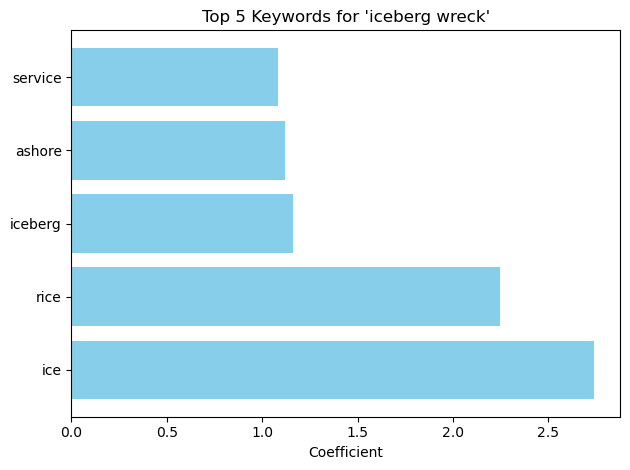

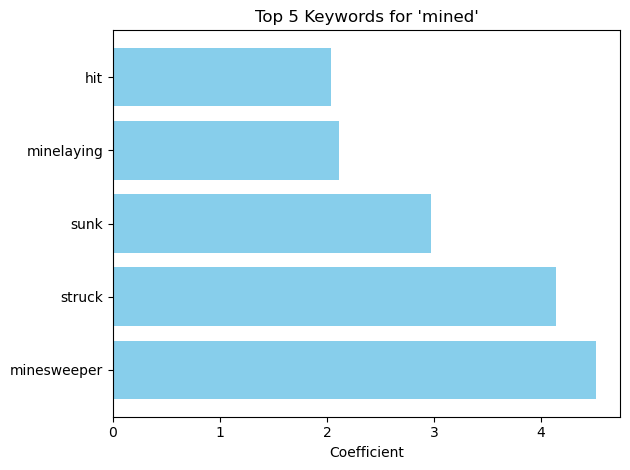

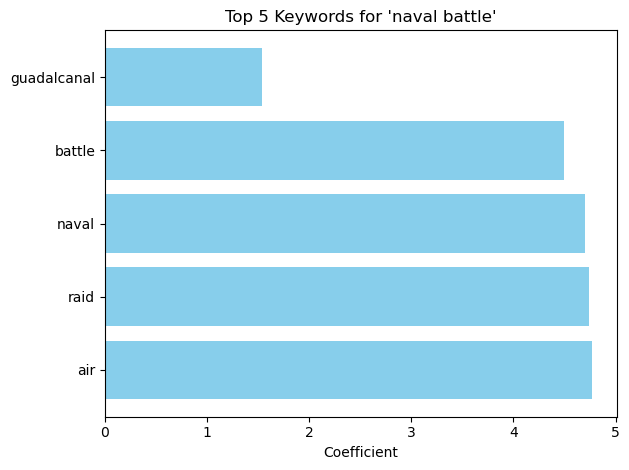

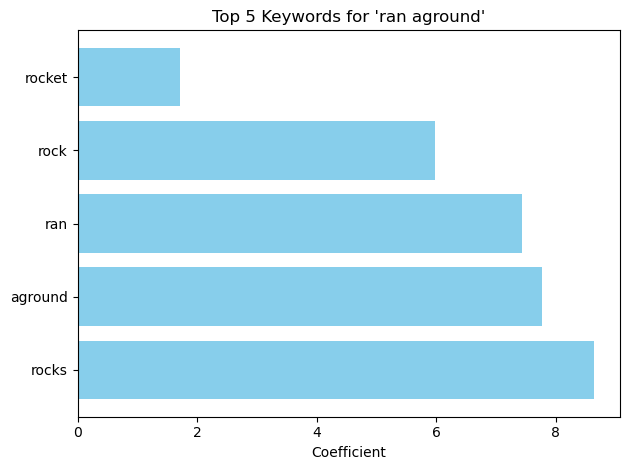

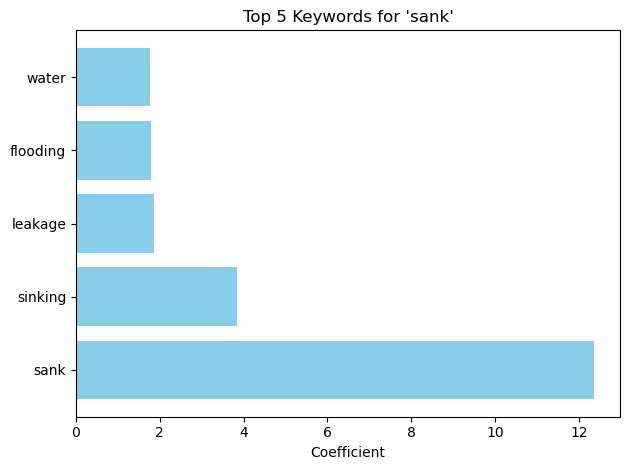

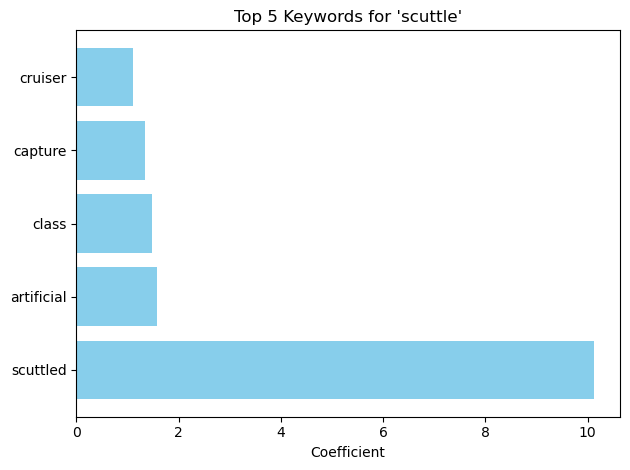

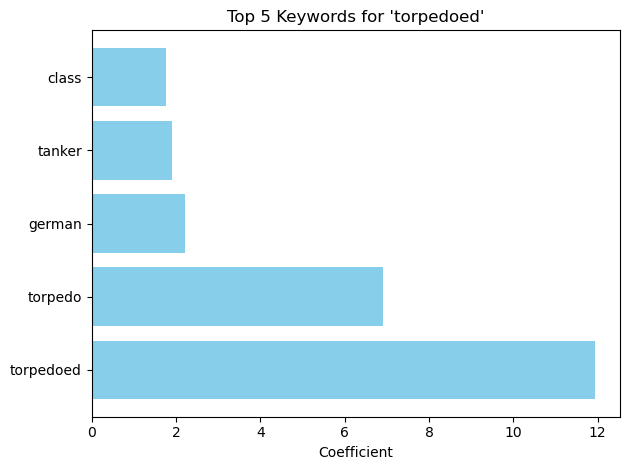

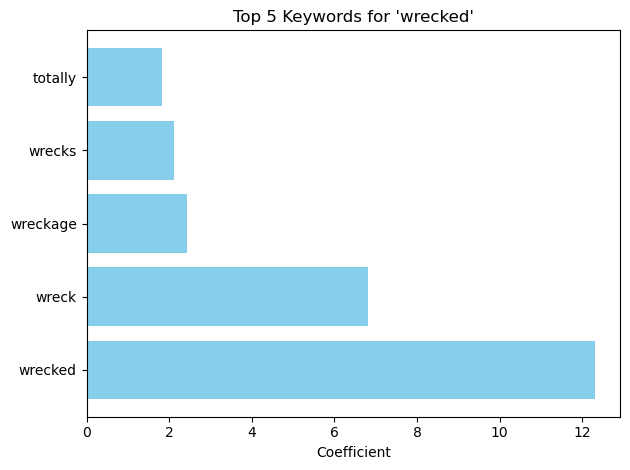

In [47]:
import matplotlib.pyplot as plt
import numpy as np

classes_model = lr.classes_
coefficients = lr.coef_
feature_names = vectorizer.get_feature_names_out()
top_n = 5  # show top 5 keywords per class

for i, class_label in enumerate(classes_model):
    coef = coefficients[i]
    top_idx = np.argsort(coef)[-top_n:]  # top N features
    top_features = [feature_names[j] for j in top_idx]
    top_values = coef[top_idx]

    # Simple bar chart
    plt.barh(top_features[::-1], top_values[::-1], color='skyblue')
    plt.xlabel("Coefficient")
    plt.title(f"Top {top_n} Keywords for '{class_label}'")
    plt.tight_layout()
    plt.show()


In [48]:
#choose better Model for Prediction
from sklearn.ensemble import RandomForestClassifier

X = df['description']
y = df['cause']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1,2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_vec, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=25, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [49]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test_vec)
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

   bad weather       0.97      0.90      0.93       102
     collision       0.99      0.97      0.98       108
fire/explosion       0.97      0.87      0.92       120
     foundered       0.98      0.97      0.97      1024
 iceberg wreck       0.50      0.10      0.17        10
         mined       0.62      0.50      0.55        66
  naval battle       1.00      1.00      1.00        56
   ran aground       0.98      0.90      0.94       162
          sank       0.89      0.99      0.94       180
       scuttle       0.88      1.00      0.93        49
     torpedoed       0.99      0.99      0.99       190
       wrecked       0.93      0.99      0.96       613

      accuracy                           0.95      2680
     macro avg       0.89      0.85      0.86      2680
  weighted avg       0.95      0.95      0.95      2680



In [50]:
high_risk = [
 'bad weather', 'collision', 'fire/explosion',
 'iceberg wreck', 'naval battle', 'torpedoed'
]

def cause_to_risk(probs, classes):
    return sum(p for p,c in zip(probs, classes) if c in high_risk)


In [51]:
def rf_risk_predict(text, threshold=0.4):
    vec = vectorizer.transform([text])
    probs = rf.predict_proba(vec)[0]
    risk = cause_to_risk(probs, rf.classes_)

    label = "High Risk" if risk >= threshold else "Low Risk"
    return {
        "Label": label,
        "Risk %": round(risk*100, 2),
        "Top Cause": rf.classes_[np.argmax(probs)]
    }


In [52]:
rf_risk_predict("ship sank in torpedoed")


{'Label': 'High Risk', 'Risk %': 60.49, 'Top Cause': 'torpedoed'}

In [53]:
def top_5_causes(text):
    vec = vectorizer.transform([text])
    probs = rf.predict_proba(vec)[0]
    classes = rf.classes_

    ranked = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)

    return ranked[:5]


In [54]:
top_5_causes("ship sank in cyclone")


[('sank', 0.32709648382169404),
 ('bad weather', 0.13212912651424014),
 ('collision', 0.0839113899766899),
 ('fire/explosion', 0.08058971845034778),
 ('mined', 0.07455635150213602)]

In [56]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df['cause'])


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    df['description'], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [58]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_vec, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [69]:
class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))
class_names

array(['bad weather', 'collision', 'fire/explosion', 'foundered',
       'iceberg wreck', 'mined', 'naval battle', 'ran aground', 'sank',
       'scuttle', 'torpedoed', 'wrecked'], dtype=object)

In [64]:
y_pred = xgb.predict(X_test_vec)


In [65]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", round(acc * 100, 2), "%")


XGBoost Accuracy: 97.84 %


In [66]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))


                precision    recall  f1-score   support

   bad weather       0.97      0.94      0.96       102
     collision       0.99      1.00      1.00       108
fire/explosion       0.98      0.90      0.94       120
     foundered       0.99      1.00      1.00      1024
 iceberg wreck       0.50      0.10      0.17        10
         mined       0.80      0.73      0.76        66
  naval battle       1.00      1.00      1.00        56
   ran aground       0.98      0.95      0.97       162
          sank       0.94      0.99      0.96       180
       scuttle       0.94      1.00      0.97        49
     torpedoed       1.00      0.99      1.00       190
       wrecked       0.98      1.00      0.99       613

      accuracy                           0.98      2680
     macro avg       0.92      0.88      0.89      2680
  weighted avg       0.98      0.98      0.98      2680



In [61]:
def top_5_causes_xgb(text):
    vec = vectorizer.transform([text])
    probs = xgb.predict_proba(vec)[0]

    classes = label_encoder.inverse_transform(np.arange(len(probs)))

    ranked = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)
    return ranked[:5]


In [62]:
def xgb_risk_predict(text, threshold=0.4):
    vec = vectorizer.transform([text])
    probs = xgb.predict_proba(vec)[0]

    classes = label_encoder.inverse_transform(np.arange(len(probs)))

    risk_score = cause_to_risk(probs, classes)
    label = "High Risk" if risk_score >= threshold else "Low Risk"

    return {
        "Input": text,
        "Risk": label,
        "Risk %": round(risk_score * 100, 2),
        "Top 5 Causes": top_5_causes_xgb(text)
    }


In [63]:
xgb_risk_predict("ship sank in cyclone")


{'Input': 'ship sank in cyclone',
 'Risk': 'High Risk',
 'Risk %': 41.06,
 'Top 5 Causes': [('sank', 0.5890115),
  ('bad weather', 0.4093911),
  ('fire/explosion', 0.001087432),
  ('mined', 0.00025214878),
  ('ran aground', 0.00012361919)]}

In [67]:
import pickle

# Save TF-IDF vectorizer
with open("ship_tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save XGBoost model
with open("ship_xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

# Save Label Encoder
with open("ship_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [68]:
df=df.to_csv("ship.csv")